# Non-Iterative Problems

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from fugue_notebook import setup
setup()

<IPython.core.display.Javascript object>

In [3]:
from tune import TUNE_OBJECT_FACTORY
TUNE_OBJECT_FACTORY.set_temp_path("/tmp")

## Load Data

The [data](https://www.kaggle.com/goodwanghan/titanic-preprocessed) is from the famous [Titanic](https://www.kaggle.com/c/titanic) competition. We have preprocessed the feature set and combined with label data. For convenience, a copy of the dataset is in this repo.

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

train_set = pd.read_parquet("../../data/titanic-preprocessed/titanic.parquet")

train, test = train_test_split(train_set, test_size=0.25, random_state=0)
train

,Fare,Age,Pclass,gender,C,Q,S,Family,Title,T_A4,...,T_SOC,T_SOPP,T_SOTONO2,T_SOTONOQ,T_STONO,T_STONO2,T_WC,T_WEP,T_X,label
105,-0.489442,-0.104637,0.827377,0.737695,-0.482043,-0.307562,0.615838,-0.811922,0.666638,-0.088986,...,-0.082339,-0.058124,-0.047431,-0.130856,-0.116841,-0.082339,-0.10654,-0.058124,0.589879,0
68,-0.488854,-0.949986,0.827377,-1.355574,-0.482043,-0.307562,0.615838,1.231645,-0.947423,-0.088986,...,-0.082339,-0.058124,-0.047431,-0.130856,-0.116841,-0.082339,-0.10654,-0.058124,0.589879,1
253,-0.324253,0.049062,0.827377,0.737695,-0.482043,-0.307562,0.615838,1.231645,0.666638,-0.088986,...,-0.082339,-0.058124,-0.047431,-0.130856,-0.116841,-0.082339,-0.10654,-0.058124,-1.695262,0
320,-0.502445,-0.565736,0.827377,0.737695,-0.482043,-0.307562,0.615838,-0.811922,0.666638,-0.088986,...,-0.082339,-0.058124,-0.047431,-0.130856,-0.116841,-0.082339,-0.10654,-0.058124,-1.695262,0
706,-0.376603,1.201810,-0.369365,-1.355574,-0.482043,-0.307562,0.615838,-0.811922,-0.947423,-0.088986,...,-0.082339,-0.058124,-0.047431,-0.130856,-0.116841,-0.082339,-0.10654,-0.058124,0.589879,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,1.025945,0.740711,-1.566107,-1.355574,2.074505,-0.307562,-1.623803,1.231645,-0.947423,-0.088986,...,-0.082339,-0.058124,-0.047431,-0.130856,-0.116841,-0.082339,-0.10654,-0.058124,-1.695262,1
192,-0.490280,-0.796286,0.827377,-1.355574,-0.482043,-0.307562,0.615838,1.231645,-0.947423,-0.088986,...,-0.082339,-0.058124,-0.047431,-0.130856,-0.116841,-0.082339,-0.10654,-0.058124,0.589879,1
629,-0.492714,-0.104637,0.827377,0.737695,-0.482043,3.251373,-1.623803,-0.811922,0.666638,-0.088986,...,-0.082339,-0.058124,-0.047431,-0.130856,-0.116841,-0.082339,-0.10654,-0.058124,0.589879,0
559,-0.298078,0.510161,0.827377,-1.355574,-0.482043,-0.307562,0.615838,1.231645,-0.947423,-0.088986,...,-0.082339,-0.058124,-0.047431,-0.130856,-0.116841,-0.082339,-0.10654,-0.058124,0.589879,1


## Define the simplest case and run

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from tune import Space, Grid, Rand, RandInt, Choice

from tune_sklearn import sk_space, suggest_sk_models, suggest_sk_models_by_cv

Now, let's define sklearn search space with just one model LogisticRegression without parameter and run it

In [6]:
space = sk_space(LogisticRegression)
print(list(space))

result = suggest_sk_models(
    space,
    train, test,
    scoring="accuracy",
)

# The following code is just for demo purpose
for r in result:
    print(r.metric, r.trial.keys, r.trial.params)

NativeExecutionEngine doesn't respect num_partitions ROWCOUNT


[{'__space__model': 'sklearn.linear_model._logistic.LogisticRegression'}]
0.7847533632286996 [] {'__space__model': 'sklearn.linear_model._logistic.LogisticRegression'}


## Combine search algorithms

### Model Sweeping

In [7]:
space = sum([
    sk_space(LogisticRegression),
    sk_space(XGBClassifier, n_estimators=10, eval_metric='mlogloss')
])

result = suggest_sk_models(
    space,
    train, test,
    scoring="accuracy",
)

for r in result:
    print(r.metric, r.trial.keys, r.trial.params)

NativeExecutionEngine doesn't respect num_partitions ROWCOUNT


0.852017937219731 [] {'__space__model': 'xgboost.sklearn.XGBClassifier', 'n_estimators': 10, 'eval_metric': 'mlogloss'}


### Model Sweeping + Grid + Random

In [8]:
space = sum([
    sk_space(LogisticRegression),
    sk_space(XGBClassifier, n_estimators=Grid(5,10), max_depth=Grid(5,10), 
             learning_rate=Rand(0.01,0.99), eval_metric='mlogloss', n_jobs=1).sample(5,1)
])

result = suggest_sk_models(
    space,
    train, test,
    scoring="accuracy",
)

for r in result:
    print(r.metric, r.trial.keys, r.trial.params)

NativeExecutionEngine doesn't respect num_partitions ROWCOUNT


0.8565022421524664 [] {'__space__model': 'xgboost.sklearn.XGBClassifier', 'n_estimators': 10, 'max_depth': 10, 'learning_rate': 0.306285921179203, 'eval_metric': 'mlogloss', 'n_jobs': 1}


### Model Sweeping + Grid + Bayesian Optimization

As you see, we simply remove sample from the previous code, and leave the Rand in the search space. And the setup() of fuggle package configured that when the framework detects random parameters, it will use HyperOpt to do Bayesian Optimization to find the best value. In you own environment, you can easily change this default behavior.

In [9]:
from tune import NonIterativeObjectiveLocalOptimizer
from tune_hyperopt import HyperoptLocalOptimizer
from tune_optuna import OptunaLocalOptimizer
import optuna

optuna.logging.disable_default_handler()

def to_optimizer(obj):
    if isinstance(obj, NonIterativeObjectiveLocalOptimizer):
        return obj
    if obj is None or "hyperopt"==obj:
        return HyperoptLocalOptimizer(max_iter=20, seed=0)
    if "optuna" == obj:
        return OptunaLocalOptimizer(max_iter=20)
    raise NotImplementedError

# make default level 2 optimizer HyperoptLocalOptimizer, so you will not need to set again
TUNE_OBJECT_FACTORY.set_noniterative_local_optimizer_converter(to_optimizer)

In [10]:
space = sum([
    sk_space(LogisticRegression),
    sk_space(XGBClassifier, n_estimators=Grid(5,10), max_depth=Grid(5,10), 
             learning_rate=Rand(0.01,0.99), n_jobs=1, eval_metric='mlogloss')
])

result = suggest_sk_models(
    space,
    train, test,
    scoring="accuracy",
)

for r in result:
    print(r.metric, r.trial.keys, r.trial.params)

NativeExecutionEngine doesn't respect num_partitions ROWCOUNT


0.8609865470852018 [] {'__space__model': 'xgboost.sklearn.XGBClassifier', 'n_estimators': 10, 'max_depth': 10, 'learning_rate': 0.5281179072339418, 'n_jobs': 1, 'eval_metric': 'mlogloss'}


### Model Sweeping + Grid + Random + Bayesian Optimization

In [11]:
space = sum([
    sk_space(LogisticRegression),
    sk_space(XGBClassifier, n_estimators=Grid(5,10), learning_rate=Rand(0.01,0.99), 
             n_jobs=1, eval_metric='mlogloss') * Space(max_depth=RandInt(1,100)).sample(5,0)
])

result = suggest_sk_models(
    space,
    train, test,
    scoring="accuracy",
)

for r in result:
    print(r.metric, r.trial.keys, r.trial.params)

NativeExecutionEngine doesn't respect num_partitions ROWCOUNT


0.8699551569506726 [] {'__space__model': 'xgboost.sklearn.XGBClassifier', 'n_estimators': 10, 'learning_rate': 0.5102792654901146, 'n_jobs': 1, 'eval_metric': 'mlogloss', 'max_depth': 61}


## Partition and Train

In this particular dataset, we have a gender column, so we may consider partition the dataset partitioned by gender and for each gender we train and tune separately to find the best models respectively. This is an option we can't ignore, but the outcome is not necessarily better, we just make it very easy to try - just add partition_keys:

In [12]:
space = sum([
    sk_space(LogisticRegression),
    sk_space(XGBClassifier, n_estimators=Grid(5,10), max_depth=Grid(5,10), 
             learning_rate=Rand(0.01,0.99), n_jobs=1, eval_metric='mlogloss')
])

result = suggest_sk_models(
    space,
    train, test,
    scoring="accuracy",
    partition_keys=["gender"]
)

for r in result:
    print(r.metric, r.trial.keys, r.trial.params)

NativeExecutionEngine doesn't respect num_partitions ROWCOUNT


0.8795180722891566 [-1.3555735383351195] {'__space__model': 'xgboost.sklearn.XGBClassifier', 'n_estimators': 5, 'max_depth': 10, 'learning_rate': 0.3907506509373887, 'n_jobs': 1, 'eval_metric': 'mlogloss'}
0.8785714285714286 [0.7376951317802901] {'__space__model': 'xgboost.sklearn.XGBClassifier', 'n_estimators': 5, 'max_depth': 10, 'learning_rate': 0.3907506509373887, 'n_jobs': 1, 'eval_metric': 'mlogloss'}


In this case, separating by gender indeed helps.

## Train with Spark or Dask

With the flexible space language, it's easy to contruct a space with hundreds of configurations, and also for non-toy datasets, it could take longer time to train each model. As long as each training process can fit in one machine, we are able to fully utilize Spark or Dask to do this distributely, and you don't even need to learn them.

With the help of fuggle setup(), we let the system understand spark means a local spark cluster. For your own environment, it's easy to configure a real Spark or Dask cluster and use a string to represent it.

In [13]:
space = sum([
    sk_space(LogisticRegression),
    sk_space(XGBClassifier, n_estimators=Grid(5,10), max_depth=Grid(5,10), 
             learning_rate=Rand(0.01,0.99), n_jobs=1, eval_metric='mlogloss',
             use_label_encoder=False)
])

result = suggest_sk_models(
    space,
    train, test,
    scoring="accuracy",
    partition_keys=["gender"],
    execution_engine="spark"
)

for r in result:
    print(r.metric, r.trial.keys, r.trial.params)

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/01/17 00:37:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


0.8795180722891566 [-1.3555735383351195] {'__space__model': 'xgboost.sklearn.XGBClassifier', 'n_estimators': 5, 'max_depth': 10, 'learning_rate': 0.3907506509373887, 'n_jobs': 1, 'eval_metric': 'mlogloss', 'use_label_encoder': False}
0.8785714285714286 [0.7376951317802901] {'__space__model': 'xgboost.sklearn.XGBClassifier', 'n_estimators': 5, 'max_depth': 10, 'learning_rate': 0.3907506509373887, 'n_jobs': 1, 'eval_metric': 'mlogloss', 'use_label_encoder': False}


## Realtime Monitoring

For a non-toy case, the compute can take a while, it is fun and important to get realtime progress especially when you run distributedly. To do that, we firstly need to enable callback for an execution engine. And then we need to specify what to monitor. Again, with fuggle setup(), we are able to use simple strings to represent what we want to do. There are 2 types of built in monitors for non-iterative problems:

1. ts to monitor the up-to-date best metric collected
2. hist to motitor the histogram of metrics collected

And they will be partitioned by partition_keys

In [14]:
from typing import Optional
from tune import Monitor
from tune_notebook import (
    NotebookSimpleHist,
    NotebookSimpleRungs,
    NotebookSimpleTimeSeries,
    PrintBest,
)

def to_monitor(obj) -> Optional[Monitor]:
    if obj is None:
        return None
    if isinstance(obj, Monitor):
        return obj
    if isinstance(obj, str):
        if obj == "hist":
            return NotebookSimpleHist()
        if obj == "rungs":
            return NotebookSimpleRungs()
        if obj == "ts":
            return NotebookSimpleTimeSeries()
        if obj == "text":
            return PrintBest()
    raise NotImplementedError(obj)

TUNE_OBJECT_FACTORY.set_monitor_converter(to_monitor)

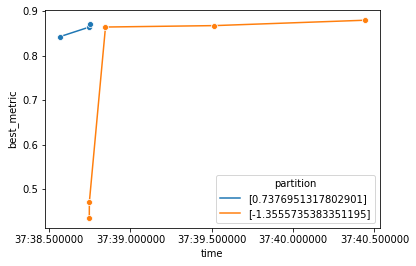

[0.7376951317802901] 0.8714285714285714 {'trial': {'trial_id': '25d80e43-563e-51c3-b5d7-4dd412a6feb8', 'params': {'__space__model': 'xgboost.sklearn.XGBClassifier', 'n_estimators': 5, 'max_depth': 10, 'learning_rate': 0.5478372338487782, 'n_jobs': 1}, 'metadata': {}, 'keys': [0.7376951317802901]}, 'metric': 0.8714285714285714, 'params': {'__space__model': 'xgboost.sklearn.XGBClassifier', 'n_estimators': 5, 'max_depth': 10, 'learning_rate': 0.5478372338487782, 'n_jobs': 1}, 'metadata': {'model': 'xgboost.sklearn.XGBClassifier'}, 'cost': 1.0, 'rung': 0, 'sort_metric': -0.8714285714285714, 'log_time': datetime.datetime(2022, 1, 17, 0, 37, 38, 578177)}
[-1.3555735383351195] 0.8795180722891566 {'trial': {'trial_id': 'fda02818-5818-5c04-8cc0-6f4530198364', 'params': {'__space__model': 'xgboost.sklearn.XGBClassifier', 'n_estimators': 5, 'max_depth': 10, 'learning_rate': 0.38577268844926216, 'n_jobs': 1}, 'metadata': {}, 'keys': [-1.3555735383351195]}, 'metric': 0.8795180722891566, 'params': {

In [15]:
space = sum([
    sk_space(LogisticRegression),
    sk_space(XGBClassifier, n_estimators=Grid(5,10), max_depth=Grid(5,10), learning_rate=Rand(0.01,0.99), n_jobs=1).sample(20,0)
])

result = suggest_sk_models(
    space,
    train, test,
    scoring="accuracy",
    partition_keys=["gender"],
    execution_engine="dask",
    execution_engine_conf={"callback":True},
    monitor="ts"
)

for r in result:
    print(r.metric, r.trial.keys, r.trial.params)

## Use Cross Validation

suggest_sk_models_by_cv should be the preferred approach to do parameter optimization, because the metric after cross validation is more robust. To use this function, we should use the entire train_set with a cv value (default 5)

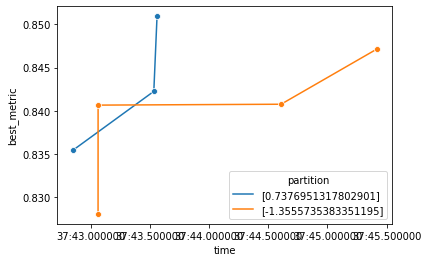

[0.7376951317802901] 0.8509445277361319 {'trial': {'trial_id': '17114a57-7822-5a65-9073-f50a6f798aaf', 'params': {'__space__model': 'xgboost.sklearn.XGBClassifier', 'n_estimators': 10, 'max_depth': 5, 'learning_rate': 0.0796153370339292, 'n_jobs': 1}, 'metadata': {}, 'keys': [0.7376951317802901]}, 'metric': 0.8509445277361319, 'params': {'__space__model': 'xgboost.sklearn.XGBClassifier', 'n_estimators': 10, 'max_depth': 5, 'learning_rate': 0.0796153370339292, 'n_jobs': 1}, 'metadata': {'model': 'xgboost.sklearn.XGBClassifier', 'cv_scores': [0.8448275862068966, 0.8620689655172413, 0.8434782608695652, 0.8608695652173913, 0.8434782608695652]}, 'cost': 1.0, 'rung': 0, 'sort_metric': -0.8509445277361319, 'log_time': datetime.datetime(2022, 1, 17, 0, 37, 43, 558896)}
[-1.3555735383351195] 0.84715821812596 {'trial': {'trial_id': 'a9dc3ef9-bbb7-5d28-bdd0-4df9367885ae', 'params': {'__space__model': 'xgboost.sklearn.XGBClassifier', 'n_estimators': 10, 'max_depth': 5, 'learning_rate': 0.438835467

In [16]:
space = sum([
    sk_space(LogisticRegression),
    sk_space(XGBClassifier, n_estimators=Grid(5,10), max_depth=Grid(5,10), learning_rate=Rand(0.01,0.99), n_jobs=1).sample(20,0)
])

result = suggest_sk_models_by_cv(
    space,
    train_set,
    cv=5,
    scoring="accuracy",
    partition_keys=["gender"],
    execution_engine="dask",
    execution_engine_conf={"callback":True},
    monitor="ts"
)

for r in result:
    print(r.metric, r.trial.keys, r.trial.params)

Notice that the metrics from the two functions are not comparable.